In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_text, DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# NOTA IMPORTANTE: AQUÍ SÓLO SE MUESTRA EL CÓDIGO NECESARIO PARA APLICAR RANDOM FOREST.

# RECUÉRDESE LA IMPORTANCIA DE LOS PASOS A SEGUIR PARA IMPLEMENTAR DE FORMA ADECUADA UN MODELO:
# (1) CARGAR BASE DE DATOS Y CONOCER FRECUENCIA DE CLASES O DISTRIBUCIÓN DE ACUERDO CON EL TIPO DE PROBLEMA.
# (2) DIVIR TRAIN, TEST Y COMPROBAR SI LA DISTRIBUCIÓN DE LA VARIABLE DEPENDIENTE ES SIMILAR EN AMBOS SETS.
# (3) AJUSTAR EL MODELO Y VALORAR LAS NECESIDADES DE INVESTIGACIÓN PARA DAR MÁS PESO A UNAS MEDIDAS DE BONDAD DE AJUSTE CON RESPECTO A OTRAS. 
# (3.1) APLICAR VALIDACIÓN CRUZADA Y, EN CASO DE NECESIDAD, UN GRIDSEARCH PARA CONOCER LAS BONDADES DE AJUSTE PARA DISTINTAS PARAMETRIZACIONES.
# (4) HACER PREDICCIONES SOBRE TRAIN Y TEST CON EL FIN DE OBSERVAR EL POSIBLE SOBREAJUSTE. VALORAR EN TEST LA CAPACIDAD PREDICTIVA DEL MODELO.
# (5) SELECCIONAR LAS ALTERNATIVAS QUE MÁS NOS INTERESEN POR SU BONDAD DE AJUSTE ESPECÍFICA.
# (6) MOSTRAR BOXPLOTS DE SU PERFORMANCE EN LAS DISTINTAS VALIDACIONES PARA VALORAR LA ROBUSTEZ Y TOMAR UNA DECISIÓN.
# (7) HACER UN INFORME DE LA PARAMETRIZACIÓN Y BONDAD DE AJUSTE DEL MODELO FINAL SELECCIONADO.

In [5]:
file_path = 'C:/Users/lrodr/OneDrive/Documentos/master_ucm/trabajos/9/datos_tarea25.xlsx'  # Reemplaza con la ruta correcta de tu archivo
df = pd.read_excel(file_path)
print(df.head())
print(f'\nLa frecuencia de cada clase es: \n{df.Color.value_counts(normalize=True)}')

   Price  Levy   Manufacturer  Prod. year   Category Leather interior  \
0  39493   891        HYUNDAI        2016       Jeep              Yes   
1   1803   761         TOYOTA        2010  Hatchback              Yes   
2   1098   394         TOYOTA        2014      Sedan              Yes   
3    941  1053  MERCEDES-BENZ        2014      Sedan              Yes   
4   1019  1055          LEXUS        2013       Jeep              Yes   

  Fuel type Engine volume    Mileage  Cylinders Gear box type Drive wheels  \
0    Diesel             2  160931 km          4     Automatic        Front   
1    Hybrid           1.8  258909 km          4     Automatic        Front   
2    Hybrid           2.5  398069 km          4     Automatic        Front   
3    Diesel           3.5  184467 km          6     Automatic         Rear   
4    Hybrid           3.5  138038 km          6     Automatic        Front   

        Wheel  Color  Airbags  
0  Left wheel  White        4  
1  Left wheel  White       1

In [6]:
df["Levy"] = pd.to_numeric(df["Levy"], errors="coerce")
df["Engine volume"] = df["Engine volume"].str.extract(r"([\d.]+)").astype(float)
df['Mileage'] = df['Mileage'].str.replace(' km', '', regex=True).astype(int)  

In [7]:
df.dtypes

Price                 int64
Levy                float64
Manufacturer         object
Prod. year            int64
Category             object
Leather interior     object
Fuel type            object
Engine volume       float64
Mileage               int32
Cylinders             int64
Gear box type        object
Drive wheels         object
Wheel                object
Color                object
Airbags               int64
dtype: object

In [8]:
df.to_excel('datos_tarea_def.xlsx', index=False)

In [9]:
nominales = ['Manufacturer', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Wheel']  # Variables sin orden
df = pd.get_dummies(df, columns=nominales, drop_first=True)
X = df.drop(columns=['Color'])
y = df['Color']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [10]:
print(f'La frecuencia de cada clase en train es: \n{y_train.value_counts(normalize=True)}')
print(f'\nLa frecuencia de cada clase en test es: \n{y_test.value_counts(normalize=True)}')

La frecuencia de cada clase en train es: 
Color
Black    0.535714
White    0.464286
Name: proportion, dtype: float64

La frecuencia de cada clase en test es: 
Color
Black    0.538018
White    0.461982
Name: proportion, dtype: float64


In [11]:
print(df.head())

   Price    Levy  Prod. year  Engine volume  Mileage  Cylinders  Color  \
0  39493   891.0        2016            2.0   160931          4  White   
1   1803   761.0        2010            1.8   258909          4  White   
2   1098   394.0        2014            2.5   398069          4  Black   
3    941  1053.0        2014            3.5   184467          6  White   
4   1019  1055.0        2013            3.5   138038          6  White   

   Airbags  Manufacturer_LEXUS  Manufacturer_MERCEDES-BENZ  \
0        4               False                       False   
1       12               False                       False   
2       12               False                       False   
3       12               False                        True   
4       12                True                       False   

   Manufacturer_TOYOTA  Category_Jeep  Category_Sedan  Leather interior_Yes  \
0                False           True           False                  True   
1                 True  

In [12]:
RF_model = RandomForestClassifier(n_estimators=60, bootstrap=True, max_depth=10, min_samples_split=6, criterion='gini', min_samples_leaf=2, random_state=123)
RF_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=6,
                       n_estimators=60, random_state=123)

In [13]:
# se procede a observar el posible sobreajuste comparando predicciones en train y test.
# predicciones significativamente mayores en train que en test puede indicar sobreajuste.
# Predicciones en conjunto de entrenamiento y prueba
y_train_pred = RF_model.predict(X_train)
y_test_pred = RF_model.predict(X_test)
print(f'Se tiene un accuracy para train de: {accuracy_score(y_train,y_train_pred)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test,y_test_pred)}')
print('Nótese la diferencia en accuracy para ambos conjuntos de datos y el posible sobreajuste.')

Se tiene un accuracy para train de: 0.8591589861751152
Se tiene un accuracy para test de: 0.7580645161290323
Nótese la diferencia en accuracy para ambos conjuntos de datos y el posible sobreajuste.


In [ ]:
params = {
    'n_estimators' : [50, 100, 150, 200],
    'max_depth': [2, 5, 10, 20, 25],
    'bootstrap': [True, False],
    'min_samples_leaf' : [1, 3, 5, 10, 20],
    'min_samples_split': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
grid_search_RF = GridSearchCV(estimator=RF_model, 
                           param_grid=params, 
                           cv=4, scoring = scoring_metrics, refit='accuracy')
grid_search_RF.fit(X_train, y_train)


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=10, min_samples_leaf=2,
                                              min_samples_split=6,
                                              n_estimators=60,
                                              random_state=123),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 5, 10, 20, 25],
                         'min_samples_leaf': [1, 3, 5, 10, 20],
                         'min_samples_split': [5, 10, 20, 50, 100],
                         'n_estimators': [50, 100, 150, 200]},
             refit='accuracy',
             scoring=['accuracy', 'precision_macro', 'recall_macro',
                      'f1_macro'])

In [16]:
best_model_RF = grid_search_RF.best_estimator_
print(grid_search_RF.best_estimator_)
y_train_pred = best_model_RF.predict(X_train)
y_test_pred = best_model_RF.predict(X_test)
print(f'Se tiene un accuracy para train de: {accuracy_score(y_train,y_train_pred)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test,y_test_pred)}')

RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=50,
                       random_state=123)
Se tiene un accuracy para train de: 0.972926267281106
Se tiene un accuracy para test de: 0.782258064516129


In [39]:
params2 = {
    'n_estimators': [100, 150, 200, 300],  # Menos árboles para evitar sobreajuste
    'max_depth': [2, 5, 8, 10],  # Reducimos profundidad máxima
    'min_samples_leaf': [20, 40, 60, 80],  # Evitamos hojas con pocos datos
    'min_samples_split': [50, 80, 120, 160],  # Evitamos splits con pocas muestras
    'max_features': ['sqrt', 'log2'],  # Limitamos las features por árbol
    'bootstrap': [True],  # Usamos bootstrap para más generalización
    'criterion': ["gini", "entropy"]  # Probamos ambos criterios
}
scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
grid_search_RF = GridSearchCV(estimator=RF_model, 
                           param_grid=params2, 
                           cv=4, scoring = scoring_metrics, refit='accuracy')
grid_search_RF.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=10, min_samples_leaf=2,
                                              min_samples_split=6,
                                              n_estimators=60,
                                              random_state=123),
             param_grid={'bootstrap': [True], 'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 5, 8, 10],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [20, 40, 60, 80],
                         'min_samples_split': [50, 80, 120, 160],
                         'n_estimators': [100, 150, 200, 300]},
             refit='accuracy',
             scoring=['accuracy', 'precision_macro', 'recall_macro',
                      'f1_macro'])

In [40]:
best_model_RF = grid_search_RF.best_estimator_
print(grid_search_RF.best_estimator_)
y_train_pred = best_model_RF.predict(X_train)
y_test_pred = best_model_RF.predict(X_test)
print(f'Se tiene un accuracy para train de: {accuracy_score(y_train,y_train_pred)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test,y_test_pred)}')

RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_leaf=20,
                       min_samples_split=50, n_estimators=300,
                       random_state=123)
Se tiene un accuracy para train de: 0.7546082949308756
Se tiene un accuracy para test de: 0.6970046082949308


In [41]:
results = pd.DataFrame(grid_search_RF.cv_results_)
sorted_results = results.sort_values(by='mean_test_accuracy', ascending=False)
res_0 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[0]
res_1 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[1]
res_2 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[2]
res_3 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[3]
res_4 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[4]
res_5 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[5]
res_10 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[10]
res_15 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[15]

C:\Users\lrodr\AppData\Local\Temp\ipykernel_16552\534662342.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([res_0.values,res_1.values,res_2.values,res_3.values,res_4.values,res_5.values,res_10.values,res_15.values], labels = ['res_0','res_1','res_2','res_3','res_4','res_5','res_10','res_15'])


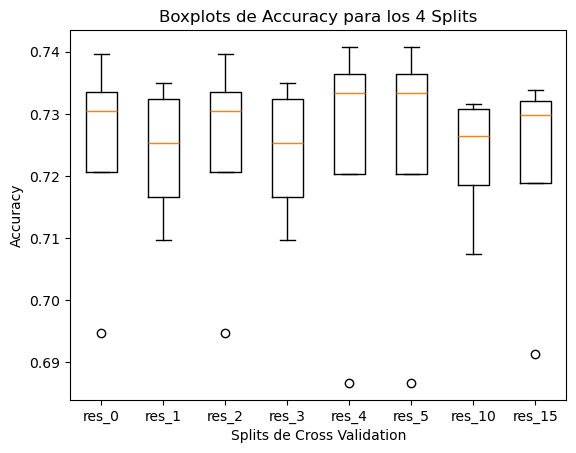

In [42]:
plt.boxplot([res_0.values,res_1.values,res_2.values,res_3.values,res_4.values,res_5.values,res_10.values,res_15.values], labels = ['res_0','res_1','res_2','res_3','res_4','res_5','res_10','res_15'])
plt.title('Boxplots de Accuracy para los 4 Splits')
plt.xlabel('Splits de Cross Validation')
plt.ylabel('Accuracy')
plt.show()

In [52]:
random_f_def = RandomForestClassifier(**sorted_results['params'].iloc[15],random_state=123)
modelo_RF = random_f_def.fit(X_train, y_train)

In [53]:
# se procede a observar el posible sobreajuste comparando predicciones en train y test.
# predicciones significativamente mayores en train que en test puede indicar sobreajuste.
# Predicciones en conjunto de entrenamiento y prueba
y_train_pred = modelo_RF.predict(X_train)
y_test_pred = modelo_RF.predict(X_test)
print(f'Se tiene un accuracy para train de: {accuracy_score(y_train,y_train_pred)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test,y_test_pred)}')
print('Comprobar que la diferencia no sea muy grande por temas de sobreajuste')

Se tiene un accuracy para train de: 0.7730414746543779
Se tiene un accuracy para test de: 0.717741935483871
Comprobar que la diferencia no sea muy grande por temas de sobreajuste


In [54]:
print('Resultados para Modelo')
print(classification_report(y_test, y_test_pred))

Resultados para Modelo
              precision    recall  f1-score   support

       Black       0.75      0.72      0.73       467
       White       0.69      0.71      0.70       401

    accuracy                           0.72       868
   macro avg       0.72      0.72      0.72       868
weighted avg       0.72      0.72      0.72       868

